220417-3인 이유는 2는 저번에 돌린 kowiki를 먼저 돌렸기 때문이다. 아래 코드를 하려면 저번 코드를 먼저 돌려야 된다

### Language Model
* ex) 네이버 검색, 상대방 음성인식, 인공지능 스피커


In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.0 MB/s 


In [2]:
import os
import random
import shutil
import json
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm

# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
!nvidia-smi

# google drive mount
from google.colab import drive
drive.mount('/content/drive')

# data dir
data_dir = '/content/drive/MyDrive/Colab Notebooks/Data/nlp'
os.listdir(data_dir)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Mounted at /content/drive


['kowiki', 'ko_32000.model', 'ko_32000.vocab']

In [3]:
# korean wiki dir
import os

kowiki_dir = os.path.join(data_dir, 'kowiki')
if not os.path.exists(kowiki_dir):
 os.makedirs(kowiki_dir)
os.listdir(kowiki_dir)
# kowiki_lm.json파일이 없다

['kowiki.txt.zip']

In [4]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [10]:
# n_seq : 문장의 최대길이
# n_max : 실제 문장의 최대 길이, [BOS] [EOS], n_seq - 1 값
# d_model : 단어 벡터의 embedding 차원

n_seq = 256
n_max = n_seq - 1 # [BOS], [EOS] 길이 1
d_model = 256

▷ 한국어 위키 전처리

In [6]:
# 파일 내용 확인
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z :
  with z.open('kowiki.txt') as f : 
    for i, line in enumerate(f) :
      if i >= 30 :
        break
      line = line.decode('UTF-8').strip()
      print(line)

지미 카터
제임스 얼 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다.
조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.
1962년 조지아주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주지사 선거에 낙선하지만, 1970년 조지아 주지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.
1976년 미합중국 제39대 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워서, 많은 지지를 받고 제럴드 포드 대통령을 누르고 당선되었다.
카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.
카터는 이집트와 이스라엘을 조정하여 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다. 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 그러나 1979년, 양국 간의 평화조약이 백악관에서 이루어졌다.
소련과 제2차 전략 무기 제한 협상(SALT II)에 조인했다.
카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.
임기 말, 소련의 아프가니스탄 침공 사건으로 인해 1980년 하계 올림픽에 반공국가들의 보이콧을 하였다.
그는 주이란 미국 대사관 인질 사건의 인질 구출 실패로 인한 원인으로, 1980년 제40대 대통령 선거에서 공화당의 로널드 레이건에게 패하며 재선에 실패하였다.
대한민국과의 관계
지미

In [7]:
# 파일 내용 확인(주제단위)
doc_list = []
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z :
  with z.open('kowiki.txt') as f :
    doc = []
    for i, line in enumerate(f) :
      line = line.decode('utf-8').strip()
      if len(line) == 0 :
        if len(doc) > 0 :
          doc_list.append(doc)
          print(doc)
          doc = []
      else :
        doc.append(line)
      if len(doc_list) > 9 :
        break

['지미 카터', '제임스 얼 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.', '지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다.', '조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.', '1962년 조지아주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주지사 선거에 낙선하지만, 1970년 조지아 주지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.', '1976년 미합중국 제39대 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워서, 많은 지지를 받고 제럴드 포드 대통령을 누르고 당선되었다.', '카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.', '카터는 이집트와 이스라엘을 조정하여 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다. 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 그러나 1979년, 양국 간의 평화조약이 백악관에서 이루어졌다.', '소련과 제2차 전략 무기 제한 협상(SALT II)에 조인했다.', '카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.', '임기 말, 소련의 아프가니스탄 침공 사건으로 인해 1980년 하계 올림픽에 반공국가들의 보이콧을 하였다.', '그는 주이란 미국 대사관 인질 사건의 인질 구출 실패로 인한 원인으로, 1980년 제40대 대통령 선거에서 공화당의 로널

In [11]:
# doc에서의 학습용 instance 생성
doc = doc_list[0]
chunk = []
chunk_len = 0
instance = []

for i, line in enumerate(doc) : 
  tokens = vocab.encode_as_pieces(line)
 # print(i, tokens, len(tokens))
  chunk.append(tokens)
  chunk_len += len(tokens)
  if n_max <= chunk_len or i == len(doc) - 1 :
    instance = []
    for tokens in chunk:
      instance.extend(tokens)
    instance = instance[:n_max]
    print(len(instance), instance)
    chunk = []
    chunk_len = 0

255 ['▁지미', '▁카터', '▁제임스', '▁얼', '▁카터', '▁주니어', '(', ',', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '대', '▁대통령', '▁', '(1977', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카터', '는', '▁조지아주', '▁섬', '터', '▁카운티', '▁플레', '인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과대학교', '를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전함', '·', '원자력', '·', '잠수함', '의', '▁승무원', '으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대위', '로', '▁예편', '하였고', '▁이후', '▁땅콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거', '가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주지사', '▁선거에', '▁낙선', '하지만', ',', '▁1970', '년', '▁조지아', '▁주지사', '를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아주', '▁상원의원', '을', '▁두', '번', '▁연임', '했으며', ',',

In [12]:
# train instance 생성 함수
def create_train_instance(vocab, n_max, doc):
  """
  create train instance
  :param vocab: vocabulary object
  :param n_max: max sequece number (exclude '[BOS]', '[EOS]')
  :param doc: wiki document
  :return: train instance list
  """
  instance_list = []
  chunk = []
  chunk_len = 0
  for i, line in enumerate(doc):
    tokens = vocab.encode_as_pieces(line)
    chunk.append(tokens)
    chunk_len += len(tokens)
    if n_max <= chunk_len or i == len(doc) - 1:
      instance = []
      for tokens in chunk:
       instance.extend(tokens)
      instance = instance[:n_max]
      instance_list.append(instance)
      chunk = []
      chunk_len = 0

  return instance_list

In [13]:
# 기능 확인 : rain instance 생성 함수 결과 확인
instance_list = create_train_instance(vocab, n_max, doc)
for instance in instance_list:
 print(len(instance), instance)

255 ['▁지미', '▁카터', '▁제임스', '▁얼', '▁카터', '▁주니어', '(', ',', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '대', '▁대통령', '▁', '(1977', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카터', '는', '▁조지아주', '▁섬', '터', '▁카운티', '▁플레', '인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과대학교', '를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전함', '·', '원자력', '·', '잠수함', '의', '▁승무원', '으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대위', '로', '▁예편', '하였고', '▁이후', '▁땅콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거', '가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주지사', '▁선거에', '▁낙선', '하지만', ',', '▁1970', '년', '▁조지아', '▁주지사', '를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아주', '▁상원의원', '을', '▁두', '번', '▁연임', '했으며', ',',

In [14]:
# save instance 저장 함수
def save_train_instance(vocab, n_max, doc, f):
 """
 save train instance
 :param vocab: vocabulary object
 :param n_max: max sequece number (exclude '[BOS]', '[EOS]')
 :param doc: wiki document
 :param f: save file
 """
 instance_list = create_train_instance(vocab, n_max, doc)
 for instance in instance_list:
  f.write(json.dumps({'token': instance}, ensure_ascii=False))
  f.write('\n')

In [15]:
# 전체 파일 save
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
 with z.open('kowiki.txt') as i_f:
  with open(os.path.join(kowiki_dir, 'kowiki_lm.json'), 'w') as o_f:
    doc = []
    for i, line in enumerate(i_f):
      line = line.decode('utf-8').strip()
      if len(line) == 0:
        if len(doc) > 0:
          save_train_instance(vocab, n_max, doc, o_f)
          doc = []
      else:
        doc.append(line)
    if len(doc) > 0:
      save_train_instance(vocab, n_max, doc, o_f)

In [16]:
# 파일 내용 확인
with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
 for i, line in enumerate(f):
  if i >= 9:
    break
  print(line.strip())

{"token": ["▁지미", "▁카터", "▁제임스", "▁얼", "▁카터", "▁주니어", "(", ",", "▁1924", "년", "▁10", "월", "▁1", "일", "▁~", "▁)", "는", "▁민주당", "▁출신", "▁미국", "▁39", "대", "▁대통령", "▁", "(1977", "년", "▁~", "▁1981", "년", ")", "이다", ".", "▁지미", "▁카터", "는", "▁조지아주", "▁섬", "터", "▁카운티", "▁플레", "인", "스", "▁마을에서", "▁태어났다", ".", "▁조지아", "▁공과대학교", "를", "▁졸업하였다", ".", "▁그", "▁후", "▁해군", "에", "▁들어가", "▁전함", "·", "원자력", "·", "잠수함", "의", "▁승무원", "으로", "▁일", "하였다", ".", "▁1953", "년", "▁미국", "▁해군", "▁대위", "로", "▁예편", "하였고", "▁이후", "▁땅콩", "·", "면", "화", "▁등을", "▁가", "꿔", "▁많은", "▁돈을", "▁벌", "었다", ".", "▁그의", "▁별명이", "▁\"", "땅", "콩", "▁농부", "\"", "▁(", "P", "ean", "ut", "▁F", "ar", "mer", ")", "로", "▁알려졌다", ".", "▁1962", "년", "▁조지아주", "▁상원", "▁의원", "▁선거에서", "▁낙선", "하나", "▁그", "▁선거", "가", "▁부정", "선거", "▁", "였", "음을", "▁입증", "하게", "▁되어", "▁당선", "되고", ",", "▁1966", "년", "▁조지아", "▁주지사", "▁선거에", "▁낙선", "하지만", ",", "▁1970", "년", "▁조지아", "▁주지사", "를", "▁역임했다", ".", "▁대통령이", "▁되기", "▁전", "▁조지아주", "▁상원의원", "을", "▁두", "번", "▁연임", "했으

▷ 학습용 데이터 생성

In [17]:
# 학습용 입력 및 정답 데이터 생성 확인
# make inputs and labels
with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
 for i, line in enumerate(f):
  if i >= 4:
   break
  line = json.loads(line)
  token = line['token']
  print(len(token), token)
  # token to id
  token_id = [vocab.piece_to_id(t) for t in token]
  print(len(token_id), token_id)
  # input
  input_id = [vocab.bos_id()] + token_id
  input_id += [vocab.pad_id()] * (n_seq - len(input_id))
  print(len(input_id), input_id)
  # label
  label_id = token_id + [vocab.eos_id()]
  label_id += [vocab.pad_id()] * (n_seq - len(label_id))
  print(len(label_id), label_id)
  # assert
  assert len(input_id) == len(label_id) == n_seq

255 ['▁지미', '▁카터', '▁제임스', '▁얼', '▁카터', '▁주니어', '(', ',', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '대', '▁대통령', '▁', '(1977', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카터', '는', '▁조지아주', '▁섬', '터', '▁카운티', '▁플레', '인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과대학교', '를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전함', '·', '원자력', '·', '잠수함', '의', '▁승무원', '으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대위', '로', '▁예편', '하였고', '▁이후', '▁땅콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거', '가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주지사', '▁선거에', '▁낙선', '하지만', ',', '▁1970', '년', '▁조지아', '▁주지사', '를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아주', '▁상원의원', '을', '▁두', '번', '▁연임', '했으며', ',',

In [18]:
total = 0
with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
  for i, line in enumerate(f):
   total += 1
  print(total)

865774


In [19]:
train_inputs = np.zeros((total, n_seq))
train_labels = np.zeros((total, n_seq))
with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
 for i, line in enumerate(tqdm(f, total=total)):
  line = json.loads(line)
  token = line['token']
  # token to id
  token_id = [vocab.piece_to_id(t) for t in token]
  # input
  input_id = [vocab.bos_id()] + token_id
  input_id += [vocab.pad_id()] * (n_seq - len(input_id))
  # label
  label_id = token_id + [vocab.eos_id()]
  label_id += [vocab.pad_id()] * (n_seq - len(label_id))
  # assert
  assert len(input_id) == len(label_id) == n_seq
  # set data
  train_inputs[i] = input_id
  train_labels[i] = label_id
print(train_inputs[-1][:10])
print(train_labels[-1][:10])

  0%|          | 0/865774 [00:00<?, ?it/s]

[2.0000e+00 2.3345e+04 7.9000e+01 1.0720e+03 2.0500e+02 9.0000e+00
 6.9600e+02 2.2400e+03 1.0000e+01 8.4260e+03]
[2.3345e+04 7.9000e+01 1.0720e+03 2.0500e+02 9.0000e+00 6.9600e+02
 2.2400e+03 1.0000e+01 8.4260e+03 9.0000e+00]


▷ 모델링

In [20]:
# RNN Language Model
def build_model(n_vocab, d_model, n_seq):
  """
  Language Model
  :param n_vocab: vocabulary 단어 수
  :param d_model: 단어를 의미하는 벡터의 차원 수
  :param n_seq: 문장길이 (단어 수)
  """
  inputs = tf.keras.layers.Input((n_seq,)) # (bs, n_seq)
  
  embedding = tf.keras.layers.Embedding(n_vocab, d_model)
  hidden = embedding(inputs) # (bs, n_seq, d_model)
  lstm = tf.keras.layers.LSTM(units=d_model, return_sequences=True)
  hidden = lstm(hidden) # (bs, n_seq, d_model)
  linear = tf.keras.layers.Dense(n_vocab, activation=tf.nn.softmax)
  outputs = linear(hidden) # (bs, n_seq, n_vocab)
  
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

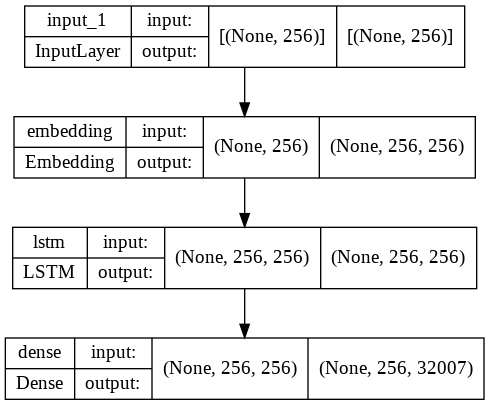

In [21]:
# NN Language Model 생성 및 확인

# 모델 생성
model = build_model(len(vocab), d_model, n_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

▷ loss 및 accuracy 함수

In [23]:
#  lm_loss 정답과 예측값 생성
# 4개 의 단어를 예측하기 위한 정답과 예측값 가정
y_true = np.random.randint(1, 3, (1, 10)).astype(np.float32)
y_true[:, 8:] = 0
y_pred = np.random.random((1, 10, 4)).astype(np.float32)
y_pred = tf.nn.softmax(y_pred, axis=-1) # 확률 값으로 변경
print(y_true)
print(y_pred)

[[2. 2. 1. 2. 1. 1. 1. 2. 0. 0.]]
tf.Tensor(
[[[0.1758568  0.17653897 0.29855365 0.34905055]
  [0.32176134 0.19165458 0.22115694 0.26542714]
  [0.29582876 0.21004662 0.25423902 0.23988554]
  [0.14406857 0.3077684  0.3434914  0.20467162]
  [0.26750565 0.15588611 0.20904896 0.36755925]
  [0.27484205 0.21315531 0.3153076  0.19669504]
  [0.22264966 0.30085495 0.19513161 0.2813638 ]
  [0.17916176 0.3138086  0.31390914 0.19312051]
  [0.33083072 0.2041551  0.32572553 0.13928865]
  [0.19949558 0.1739661  0.32583332 0.30070505]]], shape=(1, 10, 4), dtype=float32)


In [24]:
sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.
keras.losses.Reduction.NONE)
loss = sparse_entropy(y_true, y_pred)
print(loss)

tf.Tensor(
[[1.2088057 1.5088826 1.5604258 1.0685933 1.8586296 1.5457342 1.201127
  1.1586517 1.1061485 1.6119632]], shape=(1, 10), dtype=float32)


In [25]:
# make mask
mask = tf.not_equal(y_true, 0)
mask = tf.cast(mask, tf.float32)
print(mask)

tf.Tensor([[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]], shape=(1, 10), dtype=float32)


In [26]:
# lm_loss mask 적용
# mask loss
loss *= mask
print(loss)

tf.Tensor(
[[1.2088057 1.5088826 1.5604258 1.0685933 1.8586296 1.5457342 1.201127
  1.1586517 0.        0.       ]], shape=(1, 10), dtype=float32)


In [27]:
# lm_loss 함수
def lm_loss(y_true, y_pred):
 """
 pad 부분을 제외하고 loss를 계산하는 함수
 :param y_true: 정답
 :param y_pred: 예측 값
 :retrun loss: pad 부분이 제외된 loss 값
 """
 loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.
losses.Reduction.NONE)(y_true, y_pred)
 mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
 loss *= mask
 return loss

In [28]:
# lm_loss 함수 확인 : m_loss 함수 실행결과
loss = lm_loss(y_true, y_pred)
print(loss)

tf.Tensor(
[[1.2088057 1.5088826 1.5604258 1.0685933 1.8586296 1.5457342 1.201127
  1.1586517 0.        0.       ]], shape=(1, 10), dtype=float32)


In [29]:
# y_pred max value : lm_acc 예측값
y_pred_class = tf.argmax(y_pred, axis=-1)
y_pred_class = tf.cast(y_pred_class, tf.float32)
print(y_pred_class)

tf.Tensor([[3. 0. 0. 2. 3. 2. 1. 2. 0. 2.]], shape=(1, 10), dtype=float32)


In [30]:
# 정답과 일치 여부 확인 : lm_acc 정답과 예측값 일치여부 확인
matches = tf.equal(y_true, y_pred_class)
matches = tf.cast(matches, tf.float32)
matches

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 1., 0., 0., 1., 1., 1., 0.]], dtype=float32)>

In [31]:
# make mask
mask = tf.not_equal(y_true, 0)
mask = tf.cast(mask, tf.float32)
print(mask)

tf.Tensor([[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]], shape=(1, 10), dtype=float32)


In [32]:
# mask matches
matches *= mask
print(matches)

tf.Tensor([[0. 0. 0. 1. 0. 0. 1. 1. 0. 0.]], shape=(1, 10), dtype=float32)


In [33]:
# accuracy
accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
print(accuracy)

tf.Tensor(0.375, shape=(), dtype=float32)


In [34]:
def lm_acc(y_true, y_pred):
 """
 pad 부분을 제외하고 accuracy를 계산하는 함수
 :param y_true: 정답
 :param y_pred: 예측 값
 :retrun loss: pad 부분이 제외된 accuracy 값
 """
 y_true = tf.cast(y_true, tf.float32)
 y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
 matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
 mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
 matches *= mask
 accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
 return accuracy

In [35]:
# lm_acc 함수 확인
accuracy = lm_acc(y_true, y_pred)
print(accuracy)

tf.Tensor(0.375, shape=(), dtype=float32)


▷ 모델 학습

In [36]:
# RNN Language Model compile
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [37]:
# RNN Language Model callbacks
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', 
patience=10)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kowiki_dir, 
  'kowiki_lm.hdf5'), 
  monitor='lm_acc',
  verbose=1,
  save_best_only=True,
  mode="max",
  save_freq="epoch",
  save_weights_only=True)

# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kowiki_dir, 'kowiki_lm.csv'))

In [38]:
# 모델 학습(RNN Language Model 학습) - 구현하려면 1시간 걸린다고 해서 시간 관계상 중간에 종료했다
history = model.fit(train_inputs[:70000],
 train_labels[:70000],
 epochs=5,
 batch_size=32,
 callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/5
  53/2188 [..............................] - ETA: 7:45:26 - loss: 7.1946 - lm_acc: 0.0343

KeyboardInterrupt: ignored